In [ ]:
# Three questions to answer after reviewing the Seattle airbnb dataset
# Question 1 - which listing ID receives the most reviews? 
# Question 2 - Which zipcode area in Seattle receives the highest review scores & lowest review scores? 
# Question 3 - What are the relevant features to predict the pricing? 

In [1]:
# Import and read the files 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Build dataframes for the data file
df_calendar = pd.read_csv('./Downloads/Seattle_Airbnb_data/calendar.csv') 
df_listing = pd.read_csv('./Downloads/Seattle_Airbnb_data/listings.csv')
df_reviews = pd.read_csv('./Downloads/Seattle_Airbnb_data/reviews.csv') 


In [3]:
#Checking Calendar dataset
df_calendar.nunique()
df_calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

In [5]:
#Convert price column from object to float

def clean_currency(x): 
    """As Price is a string, need to remove $ sign and comma delimiter"""
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

df_calendar['listing_id'] = df_calendar['listing_id'].astype(str)
df_calendar['date'] = df_calendar['date'].astype('datetime64[ns]')
df_calendar['price'] = df_calendar['price'].apply(clean_currency).astype(float)


In [7]:
#drop NA price rows and calculate the average price by list_id when the unit is available 
df_calendar_new = df_calendar[df_calendar.available=='t'].groupby('listing_id')['price'].mean().reset_index(name = 'avg_price')
df_calendar_new.head(10)

,listing_id,avg_price
0,10000273,182.080925
1,1000883,102.916667
2,10012724,25.000000
3,10019082,131.696629
4,10020221,55.000000
5,10022421,74.000000
6,10023353,131.950673
7,10026648,65.000000
8,1002835,134.205479
9,10031055,30.402439


In [8]:
#Explore Reviews dataset
df_reviews.nunique()
df_reviews['listing_id'] = df_reviews['listing_id'].astype(str)
df_reviews_new = df_reviews.groupby('listing_id')['reviewer_id'].count().reset_index(name = 'reviewer_count')
df_reviews_new.head(10)

,listing_id,reviewer_count
0,1000883,18
1,10012724,2
2,10020221,1
3,1002835,6
4,1003890,72
5,1009838,56
6,10118341,1
7,1012003,12
8,1018204,79
9,1022135,7


In [9]:
#Merge between calendar and review datasets by listing IDs
df_match = pd.merge(df_calendar_new, df_reviews_new, on=['listing_id'], how='left')
df_match['reviewer_count'] = df_match['reviewer_count'].fillna(0)
df_match.sort_values(by='reviewer_count', ascending=False) #Listing ID was the highest reviewer count is 208356

,listing_id,avg_price,reviewer_count
450,208356,102.682353,474.0
899,365550,102.778816,466.0
551,25002,78.084416,404.0
1345,47196,67.816092,353.0
1879,63308,97.813869,320.0
...,...,...,...
2894,8156764,42.000000,0.0
2895,8156860,42.000000,0.0
2896,8156894,42.000000,0.0
2897,8157486,52.849315,0.0


In [10]:
df_match.sort_values(by='avg_price', ascending=False) #Listing ID with the highest average price is 3308979.

,listing_id,avg_price,reviewer_count
781,3308979,1301.818182,20.0
2598,7733192,1010.977716,12.0
1383,4825073,1000.000000,1.0
610,2720963,950.000000,5.0
1237,4464824,910.270718,5.0
...,...,...,...
2226,7011773,25.000000,0.0
2,10012724,25.000000,2.0
1335,4701205,25.000000,39.0
65,10248139,21.176471,1.0


In [11]:
# Explore listings dataset

df_listing['zipcode']=df_listing['zipcode'].astype(str) 
df_listing['zipcode']=df_listing['zipcode'].str[-5:] #Standardize zipcode to 5-digit code
df_listing_zip = df_listing.groupby('zipcode')['review_scores_rating'].mean().reset_index(name = 'avg_rating')
df_listing_zip.sort_values(by='avg_rating', ascending=False) #Zipcode 98146 has the highest average rating

,zipcode,avg_rating
23,98146,98.000000
24,98177,96.600000
11,98116,96.077778
5,98106,95.882353
21,98136,95.638889
18,98126,95.574468
12,98117,95.507246
16,98122,95.413699
6,98107,95.361842
14,98119,95.361345


In [14]:
# select important columns from listing dataset 

df_listing_new = df_listing[['neighbourhood_group_cleansed', 'zipcode', 'property_type',
                             'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                             'price', 'beds', 'bed_type','review_scores_rating']].copy()

df_listing_new['price'] = df_listing_new['price'].apply(clean_currency).astype(float)
df_listing_clean = df_listing_new.fillna(0)

In [15]:
#Create a new dataframe by treating categorical columns

df_listing_clean = df_listing_clean.dropna(subset=['price'], axis=0)

cat_df = df_listing_clean.select_dtypes(include=['object'])

cat_cols_list = cat_df.columns

def create_dummy_df(df, cat_cols, dummy_na):
    for col in cat_cols_list:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new = create_dummy_df(df_listing_clean, cat_cols_list, dummy_na=False)

df_new.describe()



,accommodates,bathrooms,bedrooms,price,beds,review_scores_rating,neighbourhood_group_cleansed_Beacon Hill,neighbourhood_group_cleansed_Capitol Hill,neighbourhood_group_cleansed_Cascade,neighbourhood_group_cleansed_Central Area,...,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.00000,3818.000000
mean,3.349398,1.254191,1.305657,127.976166,1.734940,78.518596,0.030906,0.148507,0.023311,0.096647,...,0.001310,0.030906,0.000786,0.000262,0.303824,0.030644,0.003405,0.019382,0.01231,0.957831
std,1.977599,0.594724,0.884219,90.250022,1.139677,35.979061,0.173086,0.355648,0.150908,0.295516,...,0.036169,0.173086,0.028024,0.016184,0.459968,0.172375,0.058260,0.137881,0.11028,0.201000
min,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,1.000000,1.000000,75.000000,1.000000,87.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,3.000000,1.000000,1.000000,100.000000,1.000000,95.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,4.000000,1.000000,2.000000,150.000000,2.000000,98.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,16.000000,8.000000,7.000000,1000.000000,15.000000,100.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


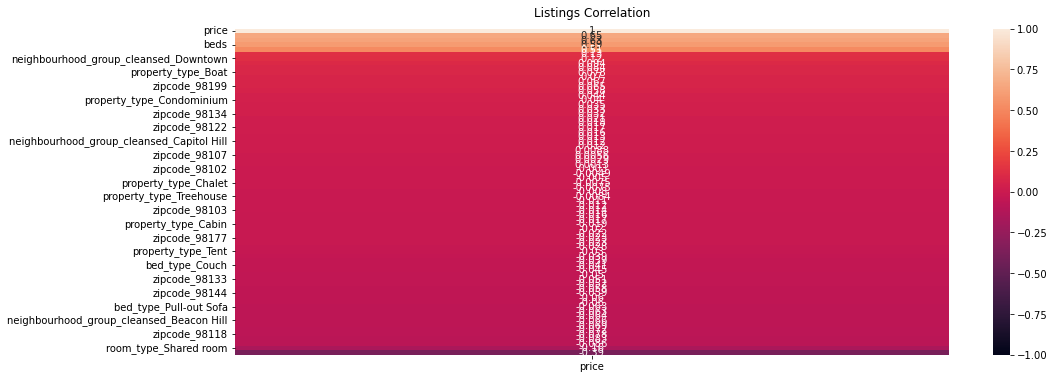

In [16]:
#Build a heatmap to show the correlation impacts of all featues against pricing
import seaborn as sns
plt.figure(figsize=(16,6))
heatmap = sns.heatmap(df_new.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Listings Correlation', fontdict={'fontsize':12}, pad=12);


In [17]:
#Display the correlation factors in order

corr_df = df_new.corr()[['price']].sort_values(by='price', ascending=False)

corr_df.head(-20)

,price
price,1.000000
accommodates,0.652218
bedrooms,0.626891
beds,0.588455
bathrooms,0.512133
bed_type_Real Bed,0.126372
neighbourhood_group_cleansed_Downtown,0.117590
neighbourhood_group_cleansed_Queen Anne,0.093789
zipcode_98119,0.083945
property_type_Boat,0.078404


In [19]:
# Testing out a Linear Regression model to predict pricing

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

price_model = df_new[['price', 'accommodates', 'bedrooms', 'beds','bathrooms']].copy()

price_model = price_model.fillna(0)

X = price_model[['accommodates', 'bedrooms', 'beds', 'bathrooms']]
y = price_model['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_test_predict = linear_reg.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.5056340307675573 on 955 value.'

In [20]:
# Testing out a random forecast model 
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.4716405441599061 on 955 value.'

In [21]:
# Testing out a Gradient Boost model


from sklearn.ensemble import GradientBoostingRegressor 

gbr_params ={'n_estimators':1000, 
             'max_depth':3, 
             'min_samples_split':5, 
             'learning_rate': 0.01, 
             'loss':'squared_error'}

gbr = GradientBoostingRegressor(**gbr_params)
gbr.fit(X_train, y_train)

y_test_predict = gbr.predict(X_test)

"The R2 value for the model is {} on {} value.".format(r2_score(y_test, y_test_predict), len(y_test))

'The R2 value for the model is 0.5128772187580086 on 955 value.'